In [1]:
import pandas as pd
from pathlib import Path

In [2]:
from fastai.vision.all import *


In [3]:
labels = pd.read_csv("../input/dog-breed-identification/labels.csv")
labels


,id,breed
0,8406d837b2d7fac1c3cd621abb4c4f9e,west_highland_white_terrier
1,e270622b5ffec8294d7e7628c4ff6c1e,brittany_spaniel
2,41295c36303043fc587e791b14ef2272,basset
3,b63b0200ddbb97df81972b26574959ab,boxer
4,2c64e362c9aa29450082291264dcba29,flat-coated_retriever
...,...,...
9194,e7af8f590b4fbdca0779f5e606ef91a1,german_shepherd
9195,79deb223049ef9f441f3fcf989897d29,great_pyrenees
9196,511bfe35ff282294f6129c55bd6c33f6,malinois
9197,f7a8a885e2b28630634c3fb513277f27,lhasa


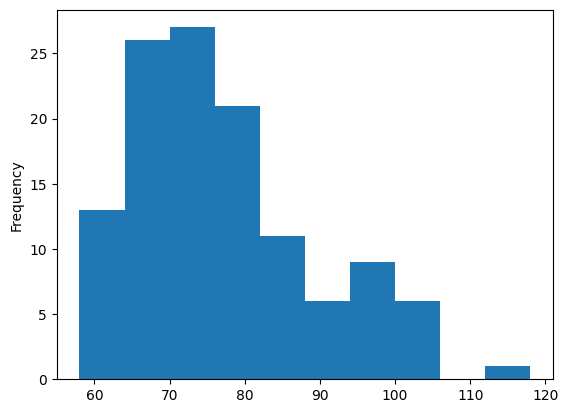

In [4]:
labels["breed"].value_counts().plot(kind="hist");


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_ids, valid_ids = next(split.split(labels, labels["breed"]))
labels["is_valid"] = [i in valid_ids for i in range(len(labels))]

labels["id"] = labels["id"].apply(lambda x: x + ".jpg")


In [6]:
path = "../input/dog-breed-identification/train"

def get_dls(size, bs):
    return ImageDataLoaders.from_df(labels, path,
                               item_tfms=Resize(460, method="squeeze"),
                               batch_tfms=[*aug_transforms(size=size),
                                           Normalize.from_stats(*imagenet_stats)],
                               bs=bs, val_bs=bs, valid_col="is_valid")

dls = get_dls(400, 32)


/usr/local/lib/python3.11/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


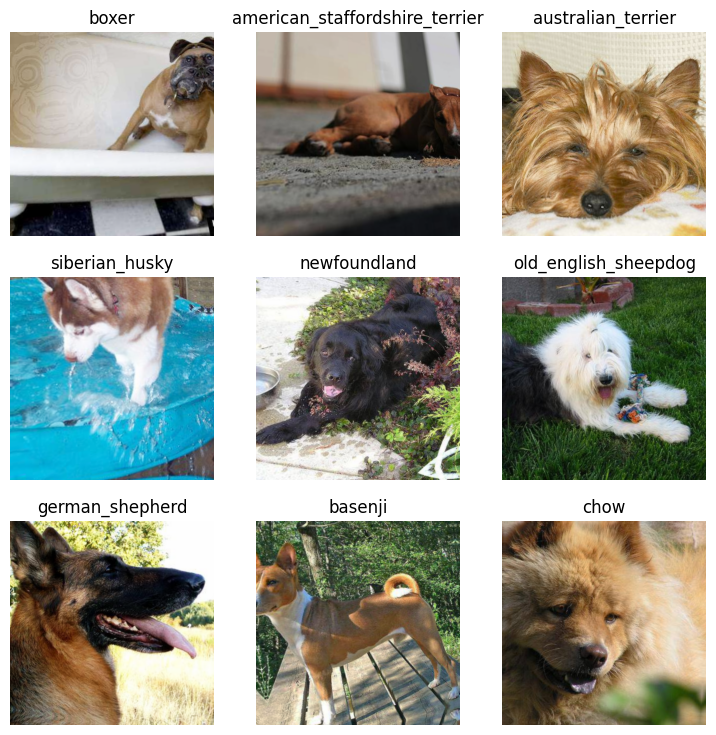

In [7]:
dls.show_batch()


In [8]:
label_count = labels["breed"].value_counts()
n_samples = labels.shape[0]
n_classes = len(dls.vocab)
weights = [n_samples / (n_classes * label_count[label]) for label in dls.vocab]
weights = tensor(weights, device="cuda")


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [9]:
learn = cnn_learner(dls, resnet101, loss_func=nn.CrossEntropyLoss(weight=weights),
                    metrics=[accuracy, F.cross_entropy], path=".").to_fp16()


TypeError: cannot assign 'list' object to buffer 'weight' (torch Tensor or None required)

In [10]:
learn.lr_find()


NameError: name 'learn' is not defined

In [11]:
learn.fit_one_cycle(3, 3e-3)


NameError: name 'learn' is not defined

In [12]:
learn.unfreeze()
learn.lr_find()


NameError: name 'learn' is not defined

In [13]:
learn.fit_one_cycle(3, slice(1e-6, 1e-4))


NameError: name 'learn' is not defined

In [14]:
test_files = get_image_files("../input/dog-breed-identification/test")
test_dl = dls.test_dl(test_files)


In [15]:
preds, targs = learn.tta(dl=test_dl)


NameError: name 'learn' is not defined

In [16]:
preds = torch.softmax(preds, dim=1)
sub = pd.DataFrame({"id":test_files.map(lambda x:x.stem)})
sub[list(dls.vocab)] = preds
sub.to_csv("submission.csv", index=False)


NameError: name 'preds' is not defined

In [17]:
sub


<function fastcore.basics.sub(a, b=<object object at 0x7f2ce1fafc30>)>